In [25]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from community import community_louvain
import random

In [26]:
def read_allegations_ipm():
    df = pd.read_csv("../data/analysis/cprr_new_orleans_pd_ipm.csv")
    return df

In [27]:
df_allegation_ipm = read_allegations_ipm()

df_allegation_ipm = df_allegation_ipm.rename(columns={"pib_control_number": "tracking_id", 
                                                      "officer_sex_x": "officer_x", "officer_race_x": "officer_race", 
                                                      "title": "rank_desc", "officer_division_x": "officer_division", 
                                                      "officer_sub_division_a_x": "officer_sub_division_a"})

df_allegation_ipm.loc[:, "disposition"] = (df_allegation_ipm.disposition_nopd
                                                            .str.lower()
                                                            .str.replace(r"resigned(.+)", "sustained", regex=True))

df_allegation_ipm = df_allegation_ipm[df_allegation_ipm.disposition.isin(["sustained"])]

df_allegation_ipm = df_allegation_ipm[["tracking_id", "uid"]]

In [28]:
def read_allegations_da():
    df = pd.read_csv("../data/clean/cprr_new_orleans_da_2016_2020.csv")
    return df

In [29]:
df_allegation_da = read_allegations_da()

df_allegation_da.loc[:, "disposition"] = (df_allegation_da.disposition 
                                                          .str.replace(r"(.+)?sustained(.+)?", "sustained", regex=True))

df_allegation_da = df_allegation_da[df_allegation_da.disposition.isin(["sustained"])]

df_allegation_da = df_allegation_da[["tracking_id", "uid"]]

In [30]:
def read_uof():
    df = pd.read_csv("../data/clean/uof_new_orleans_pd_2016_2021.csv")
    return df

In [31]:
df_uof = read_uof() 

df_uof = df_uof[["tracking_id", "uid"]] 

In [32]:
def read_sas():
    df = pd.read_csv("../data/clean/sas_new_orleans_pd_2010_2021.csv")
    return df

In [33]:
df_sas = read_sas()

df_sas = df_sas[["tracking_id", "uid"]]

C:\Users\PC\AppData\Local\Temp\ipykernel_14748\976738492.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/clean/sas_new_orleans_pd_2010_2021.csv")


In [34]:
def read_pr():
    df = pd.read_csv("../data/clean/pr_new_orleans_pd_2010_2022.csv")
    return df

In [35]:
df_epr = read_pr()

df_epr = df_epr.rename(columns={"item_number": "tracking_id"})

df_epr = df_epr[["tracking_id", "uid"]]

C:\Users\PC\AppData\Local\Temp\ipykernel_14748\1216454800.py:2: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/clean/pr_new_orleans_pd_2010_2022.csv")


In [36]:
# remove outliers 
df_allegation_ipm = df_allegation_ipm[~df_allegation_ipm.tracking_id.isin(df_allegation_ipm.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_allegation_da = df_allegation_da[~df_allegation_da.tracking_id.isin(df_allegation_da.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_uof = df_uof[~df_uof.tracking_id.isin(df_uof.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_sas = df_sas[~df_sas.tracking_id.isin(df_sas.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_epr = df_epr[~df_epr.tracking_id.isin(df_epr.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]

In [37]:
df_allegation = pd.concat([df_allegation_ipm, df_allegation_da], axis=0)

In [38]:
# filter out officers not in the allegation table
df_uof = df_uof[df_uof['uid'].isin(df_allegation['uid'])]
df_sas = df_sas[df_sas['uid'].isin(df_allegation['uid'])]
df_epr = df_epr[df_epr['uid'].isin(df_allegation['uid'])]

In [39]:
df = pd.concat([df_allegation, df_uof], axis=0)

(9932, 2)

In [40]:
d0 = df.groupby('tracking_id').count()
d1 = d0[d0.uid > 1]
group_complaints = list(set(d1.index))


df["count"] = 1
df_perUID = df.drop_duplicates(subset=["tracking_id", "uid"])
df_perUID = df_perUID.pivot_table(index=["tracking_id"], values=["count"], aggfunc="sum").reset_index()
df_perUID = df_perUID.rename(columns={"count": "no_of_officers"})
df_perUID

dict_PerComplaint = dict(zip(df_perUID.tracking_id, df_perUID.no_of_officers))

g = nx.Graph()
for incident in group_complaints:
    numberPer = dict_PerComplaint.get(incident)
    node_pairs = list(combinations(df[df.tracking_id == incident]['uid'].tolist(), 2))
    for node_pair in node_pairs:
        if g.has_edge(node_pair[0], node_pair[1]):
            g[node_pair[0]][node_pair[1]]['weight'] += (1+1/numberPer)
        else:
            g.add_edge(node_pair[0], node_pair[1], weight = (1+1/numberPer))
    if group_complaints.index(incident)%100==0:
        value = str(group_complaints.index(incident)/len(group_complaints)*100)[:5] +  "% complete "
print ("\r ", value, end = " \r "),
print("\r 100.00% complete")

print(nx.info(g))

edgeList = list(g.edges)
toRemove = [nodes for nodes in edgeList if g[nodes[0]][nodes[1]]['weight'] <=2]
g.remove_edges_from(toRemove)
g.remove_nodes_from(list(nx.isolates(g)))

print(nx.info(g))

 100.00% complete  
Graph with 1144 nodes and 3542 edges
Graph with 863 nodes and 1546 edges


C:\Users\PC\AppData\Local\Temp\ipykernel_14748\579980390.py:28: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))
C:\Users\PC\AppData\Local\Temp\ipykernel_14748\579980390.py:35: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))


In [41]:
# with open("edges.txt", "wb") as f:
#     nx.write_edgelist(g, f)

In [42]:
comms = community_louvain.best_partition(g, randomize=0)

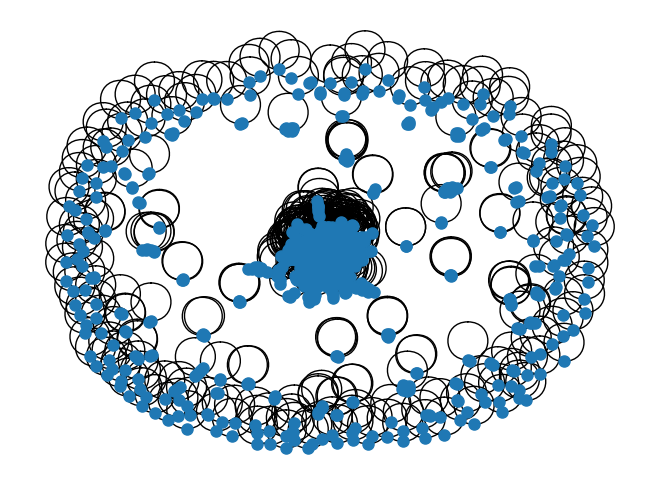

In [44]:
unique_coms = np.unique(list(comms.values()))
unique_coms

pos = nx.spring_layout(g)
nx.draw(g, pos, node_size = 64, alpha = 1)
plt.show()

In [45]:
comm_df = pd.DataFrame.from_dict(comms, orient="index").reset_index()
comm_df = comm_df.rename(columns={comm_df.columns[1]: "community", "index": "uid"})

In [46]:
comm_df

,uid,community
0,3061c76b435ac557456e24e5bd430148,0
1,e94444695438af341b4b93a95cdb3bea,0
2,96dab8486af8f52c7104875ed2406616,1
3,fdf5c7b357d628f24889a4dfa2951c2a,2
4,a37143ed633fa5d70ec5a129a4cfa4c5,3
...,...,...
858,cc4d28180b82720f4b4ec3aa85d9069b,27
859,5966a378c52370dc992e0966257f7230,23
860,5fea4eb48f50f87b587f564135df30e6,7
861,3471b0e434d07598d436c1d02748c539,206


In [47]:
comm_24 = comm_df[comm_df.community.astype(str).isin(["4"])]
comm_24

,uid,community
7,dc82163003af250b526d736fd99d081b,4
15,5fa29bd8f1b86b527693026bba7028b7,4
55,8aec556cccccb07773d2d49f16fb470e,4
186,114f1e5598de5f45cb08e67bc184e4c3,4
304,24ca721c39f8a38350ab392061d4c88d,4
401,a261b98c6e633318f9da56413e390b77,4
402,aad112a1eea9a5df3612fac4f2ddd075,4
408,a25410f76ac6e1fd994df5482ef61417,4
431,5b6e66b78400b94ef5c467087111d3fa,4
439,89c73c7635d9877dbbea1ffd75e0ffd7,4
